In [2]:
import random

In [3]:
known_weather_data = {
    'berlin': 20.0
}

def get_weather(city: str) -> float:
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

## Q1. Define function description

We want to use it as a tool for our agent, so we need to 
describe it 

How should the description for this function look like? Fill in missing parts

```python
get_weather_tool = {
    "type": "function",
    "name": "<TODO1>",
    "description": "<TODO2>",
    "parameters": {
        "type": "object",
        "properties": {
            "<TODO3>": {
                "type": "string",
                "description": "<TODO4>"
            }
        },
        "required": [TODO5],
        "additionalProperties": False
    }
}
```

What did you put in `TODO3`?

In [4]:
get_weather_tool = {
    "type": "function",
    "name": "get_weather",
    "description": "Get current temperature for a given city.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "City, eg. Berlin, New Delhi"
            }
        },
        "required": [
            "city"
        ],
        "additionalProperties": False
    }
}

## Testing it (Optional)

If you have OpenAI Key (or alternative provider),
let's test it.

A question could be "What's the weather like in Germany?"

Experiment with different system prompts to have better answers
from the system.

You can use [chat_assistant.py](https://github.com/alexeygrigorev/rag-agents-workshop/blob/main/chat_assistant.py)
or implement everything yourself 

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py
```

In [5]:
from openai import OpenAI
import chat_assistant

In [14]:
client = OpenAI()

In [15]:
tools = chat_assistant.Tools()

tools.add_tool(get_weather, get_weather_tool)
tools.get_tools()

[{'type': 'function',
  'name': 'get_weather',
  'description': 'Get current temperature for a given city.',
  'parameters': {'type': 'object',
   'properties': {'city': {'type': 'string',
     'description': 'City, eg. Berlin, New Delhi'}},
   'required': ['city'],
   'additionalProperties': False}}]

In [16]:
developer_prompt = """
You are a helpful assistant that can provide the current temperature for a given city.
Use the available tools to answer user questions about the weather.
If the user asks about a country, ask them to specify a city.
""".strip()

In [17]:
chat_interface = chat_assistant.ChatInterface()
chat = chat_assistant.ChatAssistant(
    tools=tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)

In [18]:
chat.run()

You: What's the weather in Berlin?


You: What's the weather in Delhi?


You: What's the weather in Delhi?


You: What's the weather in Kolkata?


You: stop


Chat ended.


## Q2. Adding another tool

Let's add another tool - a function that can add weather data
to our database:

```python
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'
```

Now let's write a description for it.

What did you write?

Optionally, you can test it after adding this function.

In [19]:
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'

In [20]:
set_weather_tool = {
    "type": "function",
    "name": "set_weather",
    "description": "Set the current temperature of a given city.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "City name to set the current temperature"
            },
            "temp":{
                "type": "number",
                "descripton": "Current temperature of the city"
            }
        },
        "required": [
            "city",
            "temp"
        ],
        "additionalProperties": False
    }
}

In [21]:
tools.add_tool(set_weather, set_weather_tool)

developer_prompt = """
You are a helpful assistant that can get and set the current temperature for a given city.
Use the available tools to answer user questions about the weather.
If the user asks about a country, ask them to specify a city.
When a user provides a temperature for a city, use the set_weather tool.
""".strip()

chat_interface = chat_assistant.ChatInterface()

chat = chat_assistant.ChatAssistant(
    tools=tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)

In [22]:
chat.run()

You: What's the weather in Kolkata?


You: Set the temperature in kolkata to 34 degrees celsius.


You: What's the weather in Kolkata?


You: What's the weather in Berlin?


You: Set the temp in Berlin to 15 degrees.


You: What's the weather in Berlin?


You: stop


Chat ended.


## MCP

MCP stands for Model-Context Protocol. It allows LLMs communicate
with different tools (like Qdrant). It's function calling, but 
one step further:

* A tool can export a list of functions it has
* When we include the tool to our Agent, we just need to include the link to the MCP server

## Q3. Install FastMCP

Let's install a library for MCP - [FastMCP](https://github.com/jlowin/fastmcp):

```bash
pip install fastmcp
```

What's the version of FastMCP you installed?

In [23]:
pip install fastmcp

Note: you may need to restart the kernel to use updated packages.


Ans: 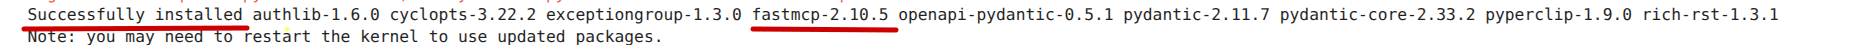

## Q4. Simple MCP Server 

A simple MCP server from the documentation looks like that:

```python
# weather_server.py
from fastmcp import FastMCP

mcp = FastMCP("Demo 🚀")

@mcp.tool
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

if __name__ == "__main__":
    mcp.run()
```

In our case, we need to write docstrings for our functions.

Let's ask ChatGPT for help:

```python
def get_weather(city: str) -> float:
    """
    Retrieves the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to retrieve weather data.

    Returns:
        float: The temperature associated with the city.
    """
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)


def set_weather(city: str, temp: float) -> None:
    """
    Sets the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to set the weather data.
        temp (float): The temperature to associate with the city.

    Returns:
        str: A confirmation string 'OK' indicating successful update.
    """
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'
```

Let's change the example for our case and run it

What do you see in the output?

Look for a string that matches this template:

```
Starting MCP server 'Demo 🚀' with transport '<TODO>'
```

What do you have instead of `<TODO>`?

### Ans: stdio
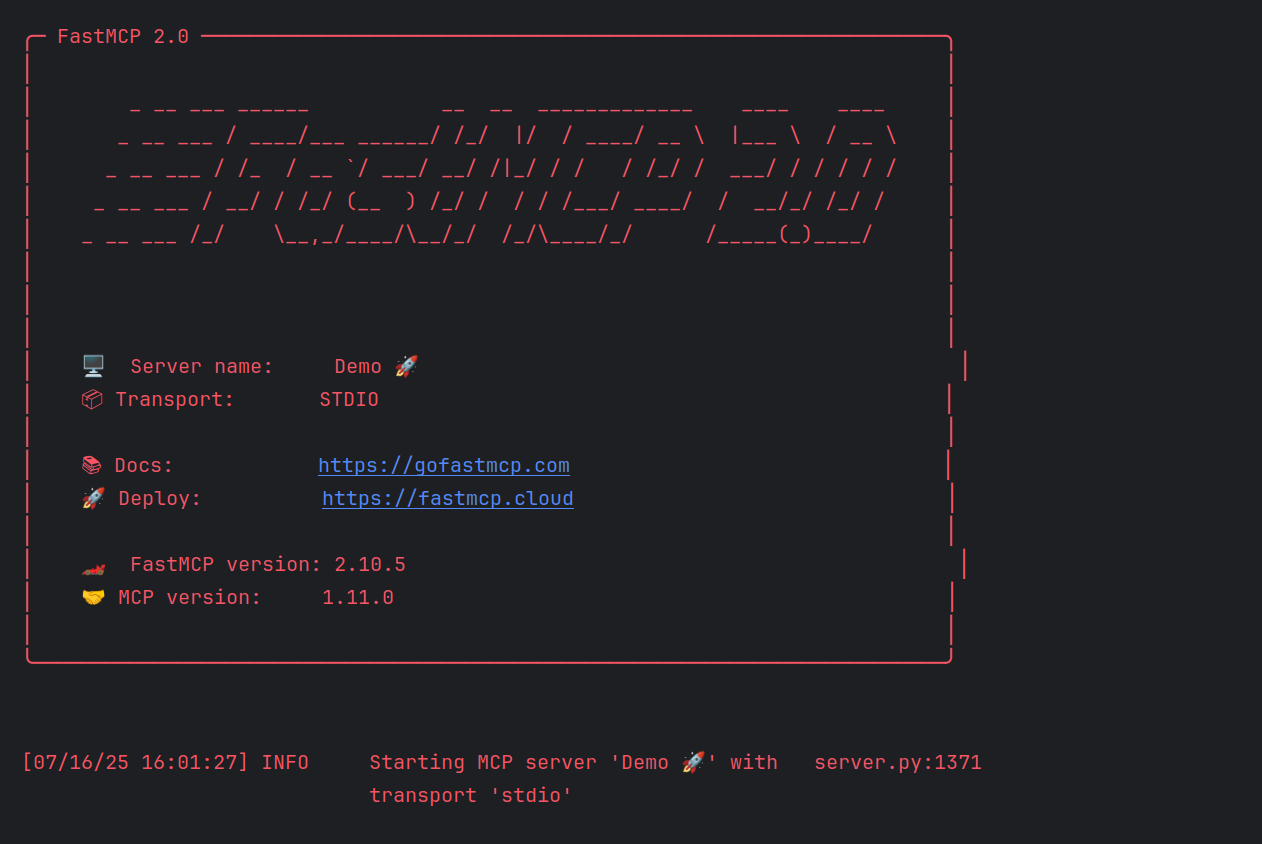

## Q5. Protocol

There are different ways to communicate with an MCP server.
Ours is currently running using standart input/output, which
means that the client write something to stdin and read the
answer using stdout.

Our weather server is currently running.

This is how we start communitcating with it:

- First, we send an initialization request -- this way, we register our client with the server:
    ```json
    {"jsonrpc": "2.0", "id": 1, "method": "initialize", "params": {"protocolVersion": "2024-11-05", "capabilities": {"roots": {"listChanged": true}, "sampling": {}}, "clientInfo": {"name": "test-client", "version": "1.0.0"}}}
    ```
    We should get back something like that, which is an aknowledgement of the request:
    ```json
    {"jsonrpc":"2.0","id":1,"result":{"protocolVersion":"2024-11-05","capabilities":{"experimental":{},"prompts":{"listChanged":false},"resources":{"subscribe":false,"listChanged":false},"tools":{"listChanged":true}},"serverInfo":{"name":"Demo 🚀","version":"1.9.4"}}}
    ```
-  Next, we reply back, confirming the initialization:
    ```json
    {"jsonrpc": "2.0", "method": "notifications/initialized"}
    ```
    We don't expect to get anything in response
- Now we can ask for a list of available methods:
    ```json
    {"jsonrpc": "2.0", "id": 2, "method": "tools/list"}
    ```
- Let's ask the temperature in Berlin:
    ```json
    {"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "<TODO>", "arguments": {<TODO>}}}
    ```
- What did you get in response?

### Ans:
{"jsonrpc":"2.0","id":3,"result":{"content":[{"type":"text","text":"20.0"}],"structuredContent":{"result":20.0},"isError":false}}

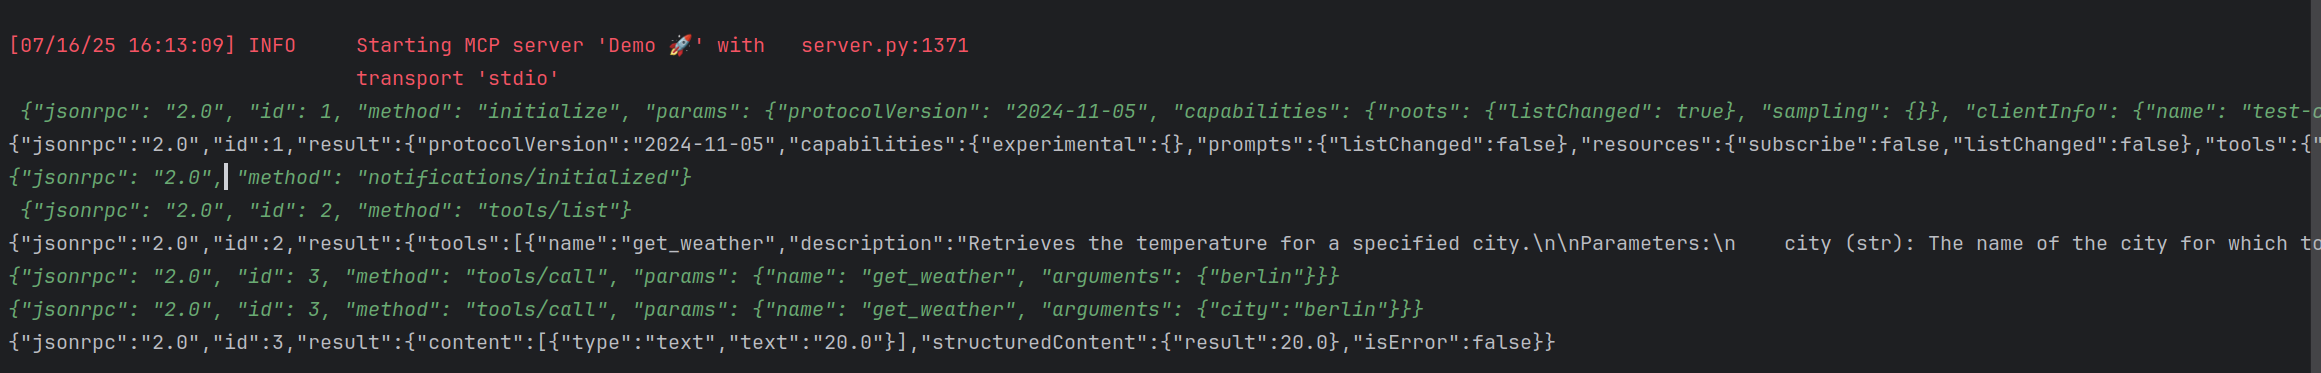

## Q6. Client

We typically don't interact with the server by copy-pasting 
commands in the terminal.

In practice, we use an MCP Client. Let's implement it. 

FastMCP also supports MCP clients:

```python
from fastmcp import Client

async def main():
    async with Client(<TODO>) as mcp_client:
        # TODO
```

Use the client to get the list of available tools
of our script. How does the result look like?

If you're running this code in Jupyter, you need to pass
an instance of MCP server to the `Client`:

```python
import weather_server

async def main():
    async with Client(weather_server.mcp) as mcp_client:
        # ....
```

If you run it in a script, you will need to use asyncio:

```python
import asyncio

async def main():
    async with Client("weather_server.py") as mcp_client:
        # ...

if __name__ == "__main__":
    test = asyncio.run(main())
```

Copy the output with the available tools when
filling in the homework form.



In [25]:
import asyncio
from fastmcp import Client
import nest_asyncio

# nest_asyncio allows the event loop to be nested, which is needed in environments like Jupyter
nest_asyncio.apply()

async def main():
    """
    Connects to the weather_server and lists its available tools.
    """
    # The client will run the weather_server.py script as a subprocess
    async with Client("weather_server.py") as mcp_client:
        tools = await mcp_client.list_tools()
        print(f"Available tools: {tools}")

# In a Jupyter Notebook, you can run the async main function like this
asyncio.run(main())

Available tools: [Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta=None), Tool(name='set_weather', title=None, description="Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.", inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}, 'tem

## Using tools from the MCP server (optional)


In [26]:
import mcp_client

our_mcp_client = mcp_client.MCPClient(["python", "weather_server.py"])

our_mcp_client.start_server()
our_mcp_client.initialize()
our_mcp_client.initialized()


Started server with command: python weather_server.py
Sending initialize request...
Initialize response: {'protocolVersion': '2024-11-05', 'capabilities': {'experimental': {}, 'prompts': {'listChanged': False}, 'resources': {'subscribe': False, 'listChanged': False}, 'tools': {'listChanged': True}}, 'serverInfo': {'name': 'Demo 🚀', 'version': '1.11.0'}}
Sending initialized notification...
Handshake completed successfully


In [27]:
our_mcp_client.get_tools()

Retrieving available tools...
Available tools: ['get_weather', 'set_weather']


[{'name': 'get_weather',
  'description': 'Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.',
  'inputSchema': {'properties': {'city': {'title': 'City', 'type': 'string'}},
   'required': ['city'],
   'type': 'object'},
  'outputSchema': {'properties': {'result': {'title': 'Result',
     'type': 'number'}},
   'required': ['result'],
   'title': '_WrappedResult',
   'type': 'object',
   'x-fastmcp-wrap-result': True}},
 {'name': 'set_weather',
  'description': "Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.",
  'inputSchema': {'properties': {'city': {'title': 'City', 'type': 'string'},
    'temp': {'title': 'Temp

In [28]:
our_mcp_client.call_tool('get_weather', {'city': 'Berlin'})

Calling tool 'get_weather' with arguments: {'city': 'Berlin'}


{'content': [{'type': 'text', 'text': '20.0'}],
 'structuredContent': {'result': 20.0},
 'isError': False}

In [29]:
import chat_assistant

In [30]:
our_mcp_client = mcp_client.MCPClient(["python", "weather_server.py"])

our_mcp_client.start_server()
our_mcp_client.initialize()
our_mcp_client.initialized()

mcp_tools = mcp_client.MCPTools(mcp_client=our_mcp_client)

Started server with command: python weather_server.py
Sending initialize request...
Initialize response: {'protocolVersion': '2024-11-05', 'capabilities': {'experimental': {}, 'prompts': {'listChanged': False}, 'resources': {'subscribe': False, 'listChanged': False}, 'tools': {'listChanged': True}}, 'serverInfo': {'name': 'Demo 🚀', 'version': '1.11.0'}}
Sending initialized notification...
Handshake completed successfully


In [31]:
developer_prompt = """
You help users find out the weather in their cities. 
If they didn't specify a city, ask them. Make sure we always use a city.
""".strip()


In [32]:
chat_interface = chat_assistant.ChatInterface()

chat = chat_assistant.ChatAssistant(
    tools=mcp_tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)


In [33]:
chat.run()

You: What's the weather in Berlin?


Retrieving available tools...
Available tools: ['get_weather', 'set_weather']
Calling tool 'get_weather' with arguments: {'city': 'Berlin'}


You: Set the temp in Berlin to 15 degrees.


Calling tool 'set_weather' with arguments: {'city': 'Berlin', 'temp': 15}


You: What's the temp in Berlin?


Calling tool 'get_weather' with arguments: {'city': 'Berlin'}


You: What's the weather in Kolkata?


Calling tool 'get_weather' with arguments: {'city': 'Kolkata'}


You: Set the temperature in kolkata to 34 degrees celsius.


Calling tool 'set_weather' with arguments: {'city': 'Kolkata', 'temp': 34}


You: What's the weather in Kolkata?


Calling tool 'get_weather' with arguments: {'city': 'Kolkata'}


You: stop


Chat ended.
